# Setup

In [1]:
from imports import *
from utils import *
from agents import UrnAgent, QLearningAgent, TDLearningAgent
from environment import NetMultiAgentEnv, TempNetMultiAgentEnv
from simulation_function import simulation_function, temp_simulation_function

In [2]:
def analyze_results(search_results, top_n=5, sort_by='mean_reward'):
    """
    Takes parameter search results and shows the top configurations and summaries.
    """
    # Convert to DataFrame
    df = pd.DataFrame([
        {**res['params'], 'mean_reward': res['mean_reward'], 'std_reward': res['std_reward'], 'mean_final_nmi': res.get('mean_final_nmi', None)}
        for res in search_results
    ])

    # Sort and show top-N
    top_df = df.sort_values(by=sort_by, ascending=False).head(top_n)
    print(f"🔝 Top {top_n} Configurations by {sort_by}:\n")
    print(top_df.to_string(index=False))

    return df, top_df

In [6]:
def plot_param_sensitivity(df, reward_col='mean_reward', error_col='std_reward', nmi_col='mean_final_nmi'):
    import matplotlib.pyplot as plt

    param_cols = [col for col in df.columns if col not in [reward_col, error_col, nmi_col]]

    num_params = len(param_cols)
    fig, axes = plt.subplots(num_params, 1, figsize=(8, 4 * num_params))

    if num_params == 1:
        axes = [axes]

    for i, param in enumerate(param_cols):
        ax = axes[i]
        grouped = df.groupby(param).agg({reward_col: 'mean', error_col: 'mean', nmi_col: 'mean'}).reset_index()

        ax.errorbar(grouped[param], grouped[reward_col], yerr=grouped[error_col], fmt='o-', capsize=5, label='Mean Reward')
        ax.set_xlabel(param)
        ax.set_ylabel('Mean Reward')
        ax.set_title(f'Effect of {param} on Reward')

        if nmi_col in df.columns:
            for j, row in grouped.iterrows():
                ax.annotate(f"NMI={row[nmi_col]:.2f}", (row[param], row[reward_col]), fontsize=8)

        ax.grid(True)

    plt.tight_layout()
    plt.show()

def plot_pairwise_performance(results):
    df = pd.DataFrame([
        {**r['params'], 'mean_reward': r['mean_reward'], 'mean_final_nmi': r['mean_final_nmi']}
        for r in results
    ])
    sns.pairplot(df, diag_kind='kde', corner=True,
                 plot_kws={'alpha': 0.7},
                 hue=None)
    plt.suptitle('Pairwise Parameter Exploration (Reward & NMI)', y=1.02)
    plt.show()

# QLearning Agent

In [ ]:
def parameter_search(
    param_ranges,
    n_simulations=200,
    n_trials=50,
    n_episodes=5000,
    base_seed=42
):
    results = []

    for sim_id in range(n_simulations):
        seed = base_seed + sim_id
        np.random.seed(seed)
        random.seed(seed)

        # Sample one parameter set from ranges
        params = {
            k: random.uniform(*v) for k, v in param_ranges.items()
        }

        trial_rewards = []
        trial_nmis = []

        for trial in range(n_trials):
            trial_seed = seed + trial * 1000
            np.random.seed(trial_seed)
            random.seed(trial_seed)

            # Setup graph
            G = nx.DiGraph()
            G.add_nodes_from([0, 1])
            G.add_edges_from([(0, 1), (1, 0)])

            # Setup game and env
            n_agents = 2
            n_features = 2
            n_signaling_actions = 2
            n_final_actions = 4
            agents_observed_variables = {0: [0], 1: [1]}
            game = {i: create_random_canonical_game(n_features, n_final_actions, n=1, m=0)
                    for i in range(n_agents)}

            env = NetMultiAgentEnv(
                n_agents=n_agents,
                n_features=n_features,
                n_signaling_actions=n_signaling_actions,
                n_final_actions=n_final_actions,
                full_information=False,
                game_dicts=game,
                observed_variables=agents_observed_variables,
                agent_type=QLearningAgent,
                initialize=False,
                graph=G
            )

            # Override agents manually with hyperparameters
            env.agents = [
                QLearningAgent(
                    n_signaling_actions=n_signaling_actions,
                    n_final_actions=n_final_actions,
                    exploration_rate=params['exploration_rate'],
                    exploration_decay=params['exploration_decay'],
                    min_exploration_rate=params['min_exploration_rate'],
                    initialize=False
                ) for _ in range(n_agents)
            ]

            _, rewards_history, signal_information_history, _, _ = simulation_function(
                n_agents=n_agents,
                n_features=n_features,
                n_signaling_actions=n_signaling_actions,
                n_final_actions=n_final_actions,
                n_episodes=n_episodes,
                with_signals=True,
                plot=False,
                env=env,
                verbose=False
            )

            # Measure average reward in last 10% of episodes
            final_rewards = [
                np.mean(rewards[-n_episodes // 10:]) for rewards in rewards_history
            ]
            trial_rewards.append(np.mean(final_rewards))

            # Measure final normalized mutual information
            final_nmi = [
                np.mean(agent_nmi[-n_episodes // 10:]) if len(agent_nmi) >= n_episodes // 10 else 0.0
                for agent_nmi in signal_information_history
            ]
            trial_nmis.append(np.mean(final_nmi))

        result = {
            'params': params,
            'mean_reward': np.mean(trial_rewards),
            'std_reward': np.std(trial_rewards),
            'mean_final_nmi': np.mean(trial_nmis)
        }
        results.append(result)
        print(f"Simulation {sim_id + 1}: {params} => Mean Reward: {result['mean_reward']:.3f}, Mean NMI: {result['mean_final_nmi']:.3f}, Std Reward: {result['std_reward']:.3f}")

    return sorted(results, key=lambda r: -r['mean_reward'])


# Example usage
param_ranges = {
    'exploration_rate': (0.25, 1.0),
    'exploration_decay': (0.9, 0.999),
    'min_exploration_rate': (0.0001, 0.1)
}

q_search_results = parameter_search(param_ranges, n_simulations=20, n_trials=5, n_episodes=5000)

for r in q_search_results:
    print(r)

Simulation 1: {'exploration_rate': 0.7295700988434128, 'exploration_decay': 0.902476064767044, 'min_exploration_rate': 0.027575428905075014} => Mean Reward: 0.555, Mean NMI: 0.250, Std Reward: 0.171
Simulation 2: {'exploration_rate': 0.27891387950303503, 'exploration_decay': 0.9689262079410682, 'min_exploration_rate': 0.014478928817396566} => Mean Reward: 0.787, Mean NMI: 0.387, Std Reward: 0.181
Simulation 3: {'exploration_rate': 0.5564019094408703, 'exploration_decay': 0.953655228901355, 'min_exploration_rate': 0.0862174579862794} => Mean Reward: 0.727, Mean NMI: 0.427, Std Reward: 0.086
Simulation 4: {'exploration_rate': 0.4539065607880681, 'exploration_decay': 0.9483147925772399, 'min_exploration_rate': 0.00827974630287954} => Mean Reward: 0.597, Mean NMI: 0.152, Std Reward: 0.120
Simulation 5: {'exploration_rate': 0.9162010573393661, 'exploration_decay': 0.9395994452011303, 'min_exploration_rate': 0.05890315625914579} => Mean Reward: 0.750, Mean NMI: 0.465, Std Reward: 0.162
Simul

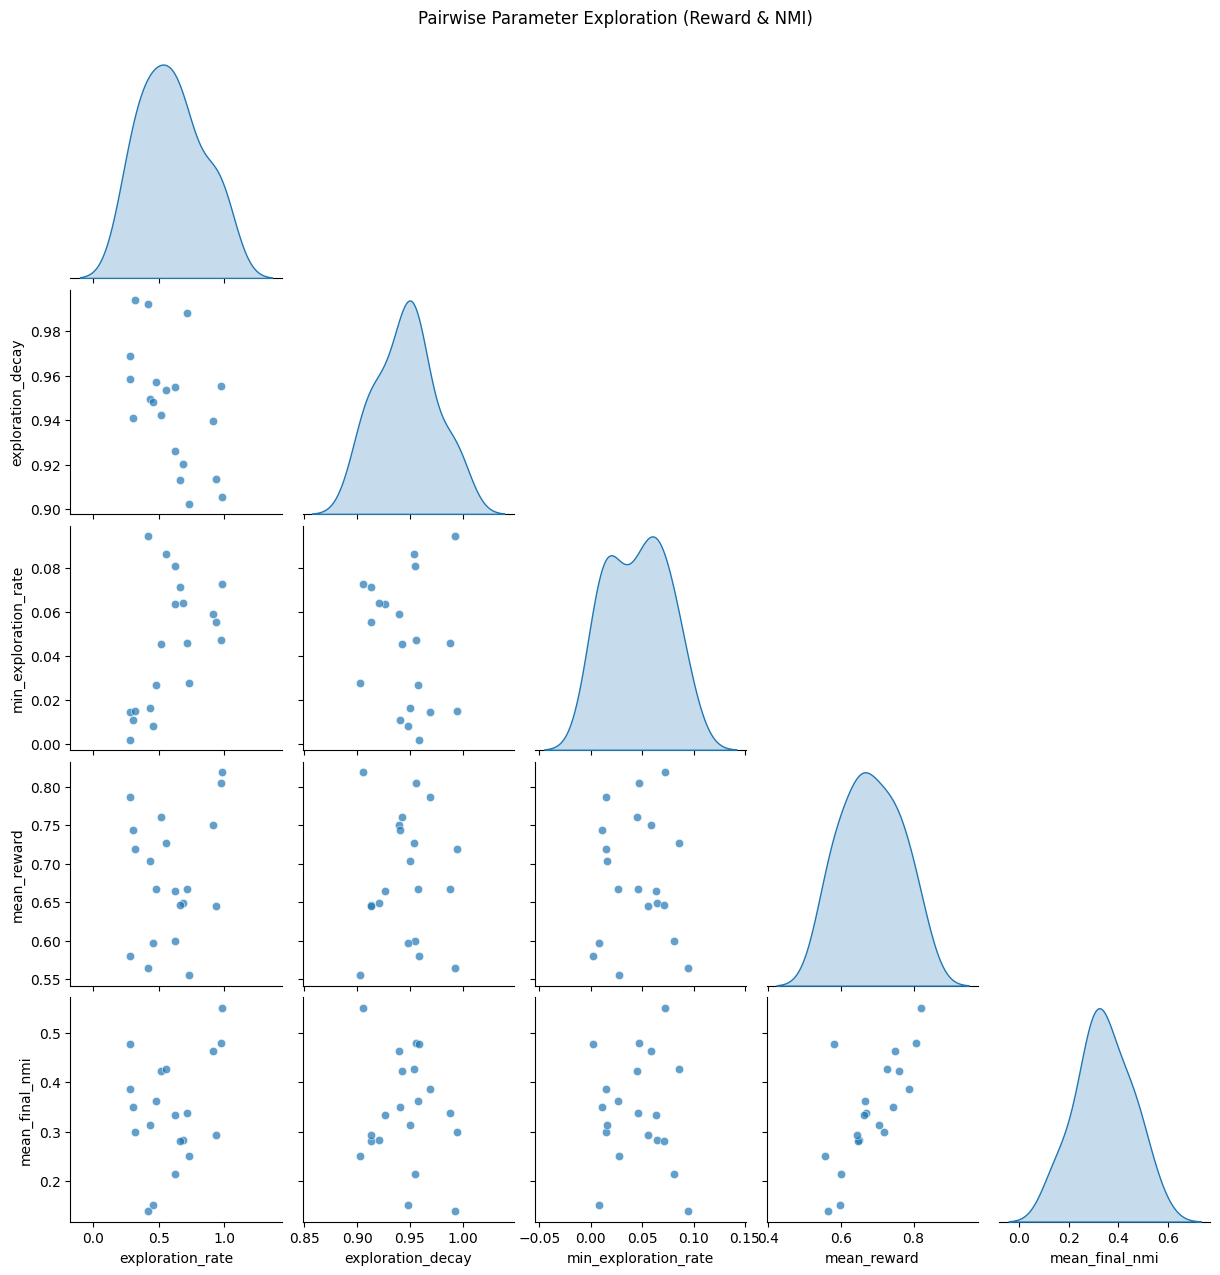

In [7]:
plot_pairwise_performance(q_search_results)


🔝 Top 5 Configurations by mean_reward:

 exploration_rate  exploration_decay  min_exploration_rate  mean_reward  std_reward  mean_final_nmi
         0.983766           0.905398              0.072594       0.8196    0.098911        0.551290
         0.974439           0.955416              0.047420       0.8056    0.179380        0.480398
         0.278914           0.968926              0.014479       0.7872    0.180953        0.387445
         0.513885           0.942588              0.045422       0.7606    0.169377        0.422123
         0.916201           0.939599              0.058903       0.7502    0.161767        0.464501


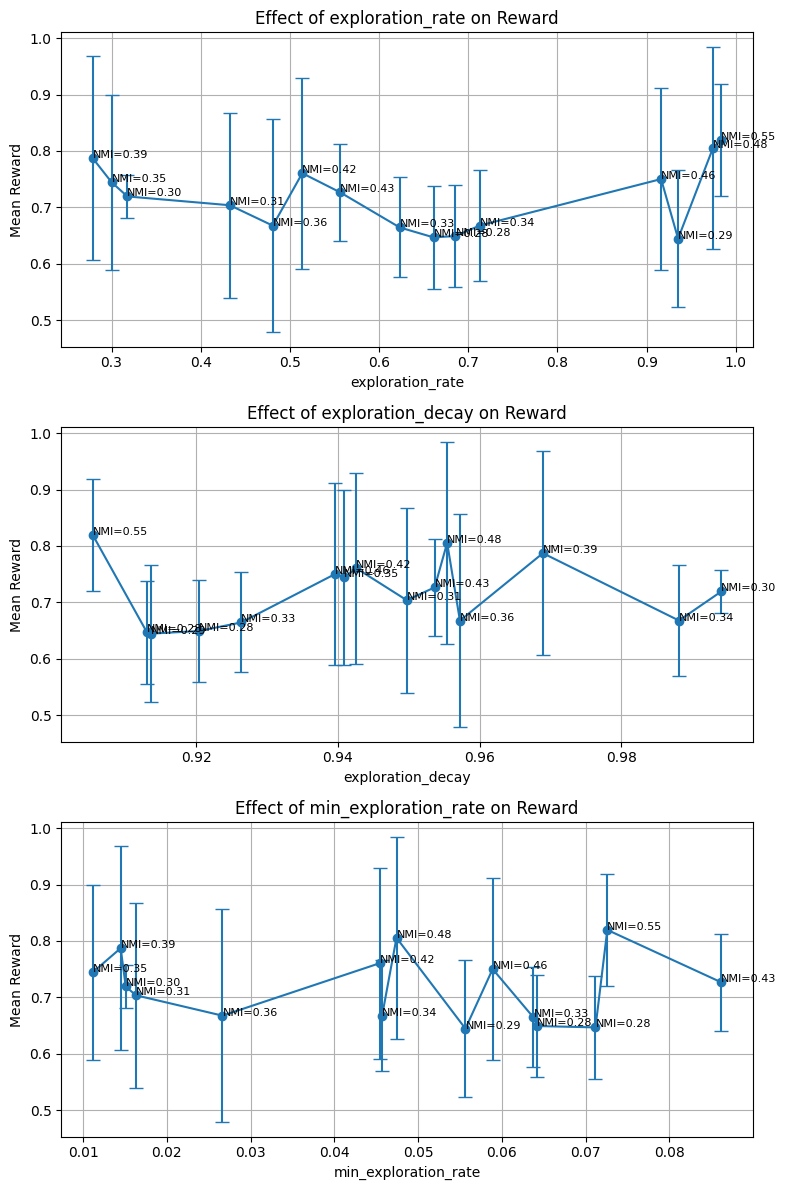

In [11]:
full_df, top_configs = analyze_results(q_search_results, top_n=5)
top_k_df = full_df.sort_values(by='mean_reward', ascending=False).head(15)
plot_param_sensitivity(top_k_df)

# TD Agent

In [ ]:
def parameter_search(
    param_ranges,
    n_simulations=200,
    n_trials=50,
    n_episodes=5000,
    base_seed=42
):
    results = []

    for sim_id in range(n_simulations):
        seed = base_seed + sim_id
        np.random.seed(seed)
        random.seed(seed)

        # Sample one parameter set from ranges
        params = {
            k: random.uniform(*v) for k, v in param_ranges.items()
        }

        trial_rewards = []
        trial_nmis = []

        for trial in range(n_trials):
            trial_seed = seed + trial * 1000
            np.random.seed(trial_seed)
            random.seed(trial_seed)

            # Setup graph
            G = nx.DiGraph()
            G.add_nodes_from([0, 1])
            G.add_edges_from([(0, 1), (1, 0)])

            # Setup game and env
            n_agents = 2
            n_features = 2
            n_signaling_actions = 2
            n_final_actions = 4
            agents_observed_variables = {0: [0], 1: [1]}
            game = {i: create_random_canonical_game(n_features, n_final_actions, n=1, m=0)
                    for i in range(n_agents)}

            env = TempNetMultiAgentEnv(
                n_agents=n_agents,
                n_features=n_features,
                n_signaling_actions=n_signaling_actions,
                n_final_actions=n_final_actions,
                full_information=False,
                game_dicts=game,
                observed_variables=agents_observed_variables,
                agent_type=TDLearningAgent,
                graph=G
            )

            # Override agents manually with hyperparameters
            env.agents = [
                TDLearningAgent(
                    n_actions=env.max_actions,
                    learning_rate=params['learning_rate'],
                    exploration_rate=params['exploration_rate'],
                    exploration_decay=params['exploration_decay'],
                    min_exploration_rate=params['min_exploration_rate']
                ) for _ in range(n_agents)
            ]

            _, rewards_history, signal_information_history, _, _ = temp_simulation_function(
                n_agents=n_agents,
                n_features=n_features,
                n_signaling_actions=n_signaling_actions,
                n_final_actions=n_final_actions,
                n_episodes=n_episodes,
                with_signals=True,
                plot=False,
                env=env,
                verbose=False
            )

            # Measure average reward in last 10% of episodes
            final_rewards = [
                np.mean(rewards[-n_episodes // 10:]) for rewards in rewards_history
            ]
            trial_rewards.append(np.mean(final_rewards))

            # Measure final normalized mutual information
            final_nmi = [
                np.mean(agent_nmi[-n_episodes // 10:]) if len(agent_nmi) >= n_episodes // 10 else 0.0
                for agent_nmi in signal_information_history
            ]
            trial_nmis.append(np.mean(final_nmi))

        result = {
            'params': params,
            'mean_reward': np.mean(trial_rewards),
            'std_reward': np.std(trial_rewards),
            'mean_final_nmi': np.mean(trial_nmis)
        }
        results.append(result)
        print(f"Simulation {sim_id + 1}: {params} => Mean Reward: {result['mean_reward']:.3f}, Mean NMI: {result['mean_final_nmi']:.3f}, Std Reward: {result['std_reward']:.3f}")

    return sorted(results, key=lambda r: -r['mean_reward'])

def plot_pairwise_performance(results):
    df = pd.DataFrame([
        {**r['params'], 'mean_reward': r['mean_reward'], 'mean_final_nmi': r['mean_final_nmi']}
        for r in results
    ])
    sns.pairplot(df, diag_kind='kde', corner=True,
                 plot_kws={'alpha': 0.7},
                 hue=None)
    plt.suptitle('Pairwise Parameter Exploration (Reward & NMI)', y=1.02)
    plt.show()

# Example usage
param_ranges = {
    'learning_rate': (0.01, 0.2),
    'exploration_rate': (0.25, 1.0),
    'exploration_decay': (0.5, 1.0),
    'min_exploration_rate': (0.0, 0.1)
}

td_search_results = parameter_search(param_ranges, n_simulations=20, n_trials=5, n_episodes=5000)

for r in td_search_results:
    print(r)

Simulation 1: {'learning_rate': 0.1314910917069979, 'exploration_rate': 0.2687580664170002, 'exploration_decay': 0.6375146591845596, 'min_exploration_rate': 0.022321073814882277} => Mean Reward: 0.759, Mean NMI: 0.079, Std Reward: 0.176
Simulation 2: {'learning_rate': 0.01732484947410221, 'exploration_rate': 0.7721682419777895, 'exploration_decay': 0.5719666106976805, 'min_exploration_rate': 0.04625322548290876} => Mean Reward: 0.487, Mean NMI: 0.000, Std Reward: 0.011
Simulation 3: {'learning_rate': 0.08762181705835381, 'exploration_rate': 0.6564790068284472, 'exploration_decay': 0.9310183082396366, 'min_exploration_rate': 0.017666564419544385} => Mean Reward: 0.625, Mean NMI: 0.161, Std Reward: 0.148
Simulation 4: {'learning_rate': 0.06165632873297725, 'exploration_rate': 0.6160211558881808, 'exploration_decay': 0.5409396711855833, 'min_exploration_rate': 0.033873348699206975} => Mean Reward: 0.643, Mean NMI: 0.071, Std Reward: 0.170
Simulation 5: {'learning_rate': 0.1787709345259727

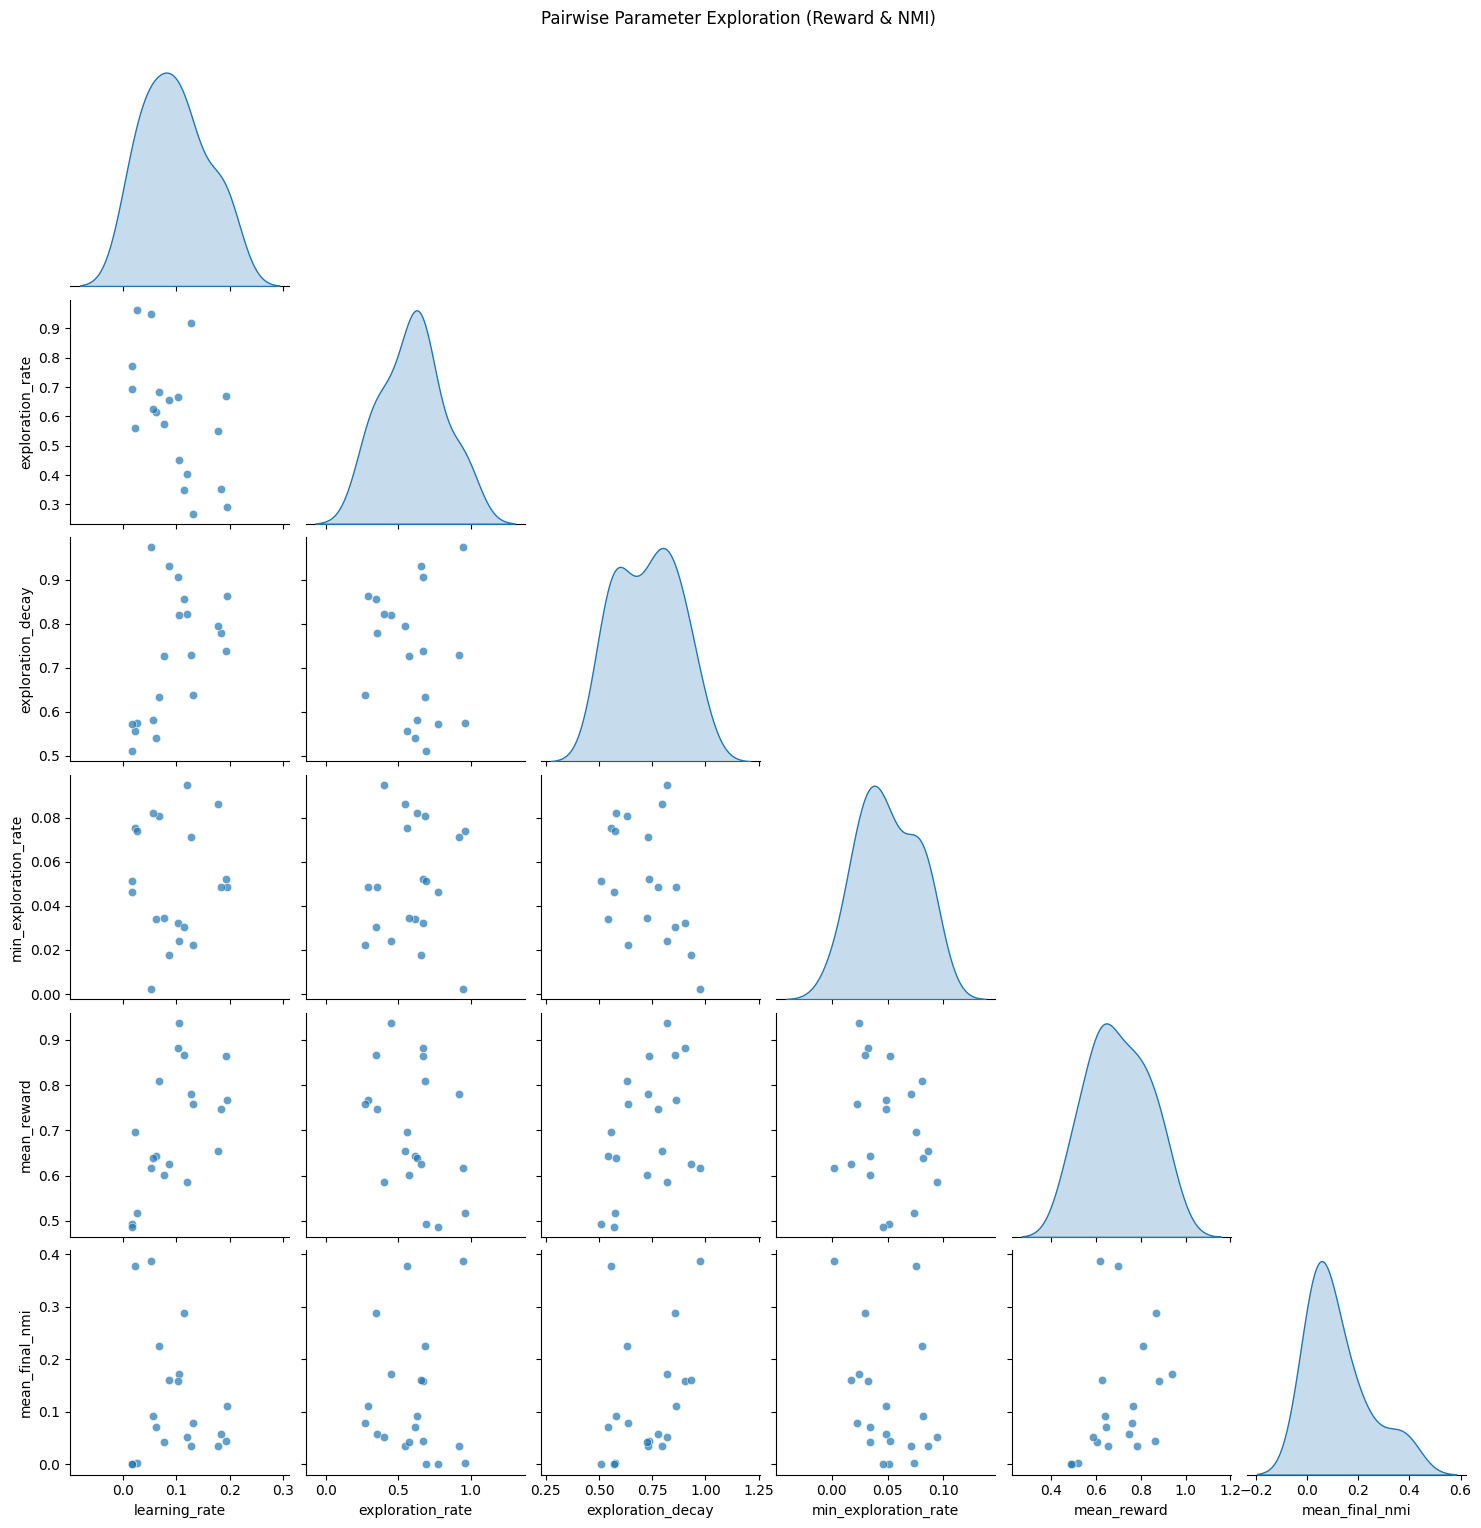

In [10]:
plot_pairwise_performance(td_search_results)


🔝 Top 5 Configurations by mean_reward:

 learning_rate  exploration_rate  exploration_decay  min_exploration_rate  mean_reward  std_reward  mean_final_nmi
      0.104532          0.449630           0.818706              0.024248       0.9372    0.071202        0.172949
      0.103953          0.667519           0.904871              0.032062       0.8824    0.149838        0.159469
      0.114150          0.348919           0.855773              0.030225       0.8654    0.170376        0.288297
      0.193525          0.669817           0.736836              0.052328       0.8636    0.070647        0.045209
      0.068483          0.683468           0.632809              0.080790       0.8088    0.118060        0.226357


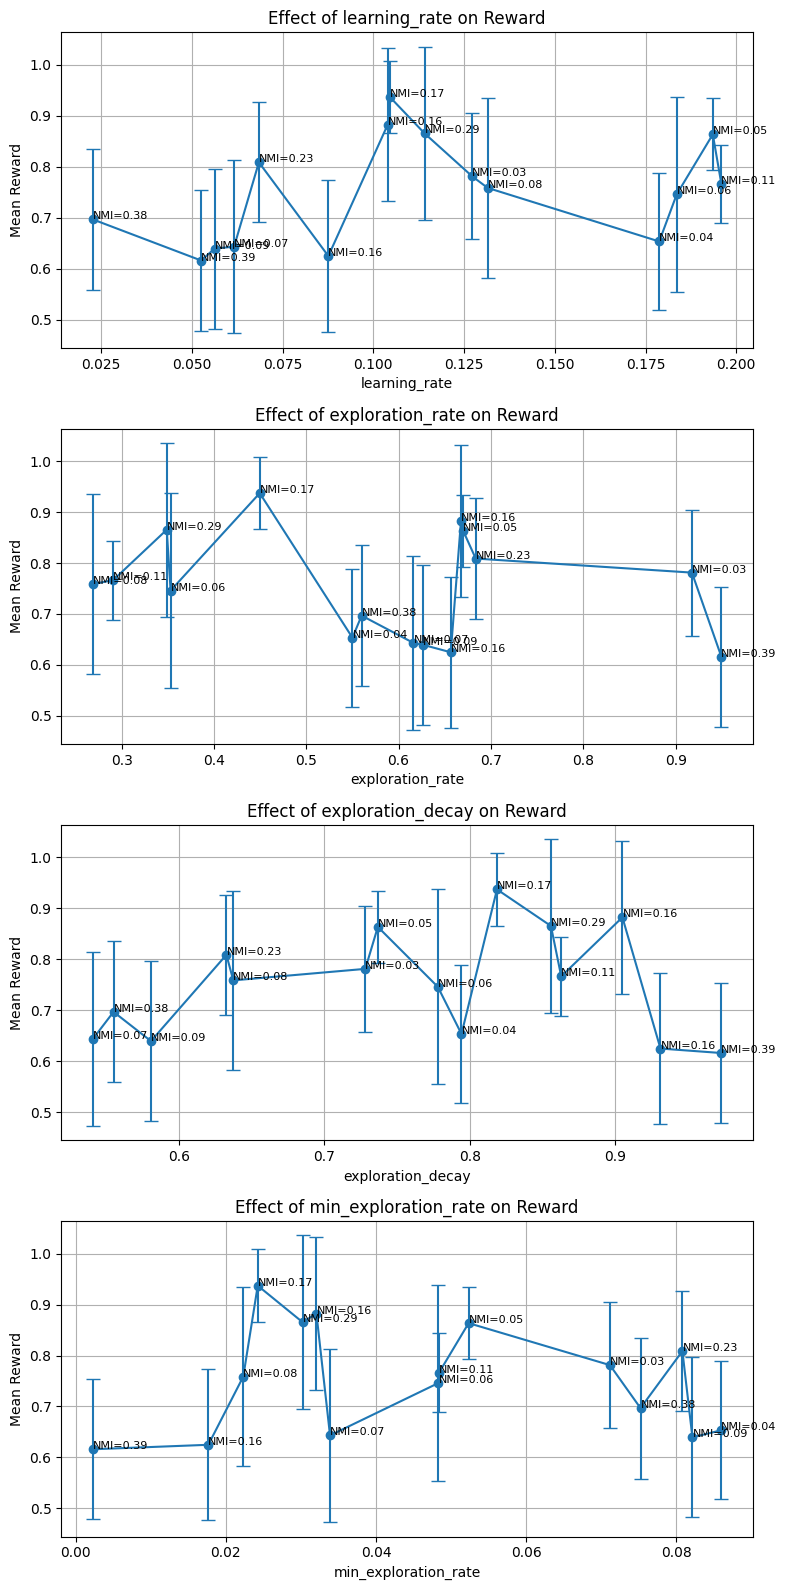

In [12]:
full_df, top_configs = analyze_results(td_search_results, top_n=5)
top_k_df = full_df.sort_values(by='mean_reward', ascending=False).head(15)
plot_param_sensitivity(top_k_df)
